Entropia 

En el orden que nosotros vamos creando las deciciones el orden en que las creemos importa mucho, para saber que tanta informaciondebemos crear en los arboles de decision es que la entreopia se hace presente 

In [1]:
import math
from functools import reduce,partial
def entropy(class_properties):
    return sum(-p * math.log(p,2)
        for p in class_properties 
        if p)

Nuestra data va a consistir en pares ( entrada, etiquetas ) , que significa que vamos a necesitar computar la classe probailidad por nuestra cuenta. Observa que aactualmente no importa cual etiqueta es asociada con cada porbabilidad, solo cual probabilidad es 

In [2]:
from collections import Counter,defaultdict
def class_probabilities(labels):
    total_count = len(labels)
    return [count/total_count for count in Counter(labels).values()]

In [3]:
def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

In [4]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum( data_entropy(subset) * len(subset) / total_count
                for subset in subsets )

In [5]:
def group_by(items, key_fn):
    """returns a defaultdict(list), where each input item
    is in the list whose key is key_fn(item)"""
    groups = defaultdict(list)
    for item in items:
        key = key_fn(item)
        groups[key].append(item)
    return groups


In [6]:
def partition_by(inputs, attribute):
    """returns a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)"""
    return group_by(inputs, lambda x: x[0][attribute])

In [7]:
def partition_entropy_by(inputs,attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

In [8]:

def classify(tree, input):
    """classify the input using the given decision tree"""
    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree

    # otherwise find the correct subtree
    attribute, subtree_dict = tree

    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree

    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input


In [9]:
def build_tree_id3(inputs, split_candidates=None):

    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues

    if num_trues == 0:                  # if only Falses are left
        return False                    # return a "False" leaf

    if num_falses == 0:                 # if only Trues are left
        return True                     # return a "True" leaf

    if not split_candidates:            # if no split candidates left
        return num_trues >= num_falses  # return the majority leaf

    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
        key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]

    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }

    subtrees[None] = num_trues > num_falses # default case

    return (best_attribute, subtrees)

def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]


if __name__ == "__main__":

    inputs = [
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
        ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
        ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
        ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
        ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
        ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
    ]

    for key in ['level','lang','tweets','phd']:
        print(key, partition_entropy_by(inputs, key))
    print()

    senior_inputs = [(input, label)
                     for input, label in inputs if input["level"] == "Senior"]

    for key in ['lang', 'tweets', 'phd']:
        print(key, partition_entropy_by(senior_inputs, key))
    print()

    print("building the tree")
    tree = build_tree_id3(inputs)
    print(tree)

    print("Junior / Java / tweets / no phd", classify(tree,
        { "level" : "Junior",
          "lang" : "Java",
          "tweets" : "yes",
          "phd" : "no"} ))

    print("Junior / Java / tweets / phd", classify(tree,
        { "level" : "Junior",
                 "lang" : "Java",
                 "tweets" : "yes",
                 "phd" : "yes"} ))

    print("Intern", classify(tree, { "level" : "Intern" } ))
    print("Senior", classify(tree, { "level" : "Senior" } ))


level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617

lang 0.4
tweets 0.0
phd 0.9509775004326938

building the tree
('level', {'Senior': ('tweets', {'no': False, 'yes': True, None: False}), 'Mid': True, 'Junior': ('phd', {'no': True, 'yes': False, None: True}), None: True})
Junior / Java / tweets / no phd True
Junior / Java / tweets / phd False
Intern True
Senior False


Primero carguemos el conjunto de datos de Pima Indian Diabetes requerido usando la función de lectura CSV de pandas.

In [10]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [11]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', '% per family', 'age', 'label']
# load dataset
pima = pd.read_csv("./recursos/diabetes.csv", header=None, names=col_names)
pima = pima.iloc[1: , :]

In [12]:
pima.head()

pregnant glucose  bp skin insulin   bmi % per family age label
1        6     148  72   35       0  33.6        0.627  50     1
2        1      85  66   29       0  26.6        0.351  31     0
3        8     183  64    0       0  23.3        0.672  32     1
4        1      89  66   23      94  28.1        0.167  21     0
5        0     137  40   35     168  43.1        2.288  33     1

- pregnant : Numero de veces embarazada
- Glocose : Concentracion en plasma despues de un test oral de 2 horas
- Bloodpresure : Diastolic blood presure (mm Hg)
- skin thickness: pliegue en triceps en mm
- insulina : 2 horas en suero (mu U/ml)
- BMI : indice de masa coportal
- % per familiy : funcion de probabilidad 0-1 dada la genetica
- Age : edad

Selección de características

In [13]:
#split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','% per family']
X = pima[feature_cols] # Features
y = pima.label # Target variable

División de datos

Para comprender el rendimiento del modelo, dividiendo el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba es una buena estrategia.

Dividamos el conjunto de datos usando la función train_test_split (). Debe pasar 3 características de parámetros, objetivo y tamaño de conjunto de prueba.

In [14]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

Creemos un modelo de árbol de decisión utilizando Scikit-learn. 
- sklearn.tree.DecisionTreeClassifier¶

In [15]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

In [16]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [17]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

Modelo de evaluación
- Vamos a estimar, con qué precisión el clasificador o modelo puede predecir el tipo de cultivares.La precisión se puede calcular comparando los valores reales del conjunto de pruebas y los valores pronosticados.

In [18]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.670995670995671


Visualizando los árboles de decisión en Machine Learning

In [25]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(400,200))  # customize according to the size of your tree!!
_ = tree.plot_tree(clf, feature_names = X.columns)
plt.show()

Intepretacion personal:

Entendemos por este grafico gigante las deciciones que se toman por cada uno de los variables para predecir que se posee diabetes, entre más alto sea el gini sera más probable que cumpla con la precision para determinar nuestra aseveracion

Optimizando el rendimiento del árbol de decisiones

Como puede ver arriba, el árbol es demasiado vasto y no tan preciso. Este árbol también lleva tiempo, por lo que para obtener mejores resultados, necesitamos optimizar el árbol ajustando el parámetro.

Aquí explicaré solo el parámetro importante del Algoritmo del árbol de decisión, su ajuste requerirá una publicación de blog completamente nueva. Si observa los parámetros que puede tomar el DecisionTreeClassifier se sorprenderá, echemos un vistazo a algunos de ellos.

criterio: Este parámetro determina cómo la impureza de Se medirá una división. El valor predeterminado es “gini”, pero también puede usar “entropía” como medida de impureza.

divisor: Así es como el árbol de decisión busca las características para una división. El valor predeterminado se establece en “mejor”. Es decir, para cada nodo, el algoritmo considera todas las características y elige la mejor división.

Si decide establecer el parámetro del divisor en “aleatorio”, se considerará un subconjunto aleatorio de características. La división se realizará por la mejor característica dentro del subconjunto aleatorio.

El tamaño del subconjunto aleatorio está determinado por el parámetro max_features. Aquí es en parte donde un bosque aleatorio recibe su nombre.

max_depth: Esto determina la profundidad máxima del árbol. En nuestro caso, usamos una profundidad de dos para hacer nuestro árbol de decisión. El valor predeterminado se establece en none.

Esto a menudo dará como resultado árboles de decisión sobreajustados. El parámetro de profundidad es una de las formas en que podemos regularizar el árbol, o limitar la forma en que crece para evitar sobreajuste .

min_samples_split: El número mínimo de muestras un nodo debe contener para considerar la división. El valor predeterminado es dos. Puede usar este parámetro para regularizar su árbol.

min_samples_leaf: El número mínimo de muestras necesarias para ser considerado un nodo hoja. El valor predeterminado se establece en uno. Use este parámetro para limitar el crecimiento del árbol.

max_features: El número de características a considerar al buscar la mejor división. Si no se establece este valor, el árbol de decisión considerará todas las características disponibles para hacer la mejor división. Dependiendo de su aplicación, a menudo es una buena idea ajustar este parámetro.

Para fines de sintaxis, establezcamos algunos de estos parámetros:

In [55]:
clfAjustado = DecisionTreeClassifier(criterion = "entropy", splitter = "random", max_depth = 4, min_samples_split = 5,min_samples_leaf = 1, max_features = 5)

In [56]:
clfAjustado = clfAjustado.fit(X_train,y_train)

In [57]:
y_pred = clfAjustado.predict(X_test)

In [58]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7402597402597403


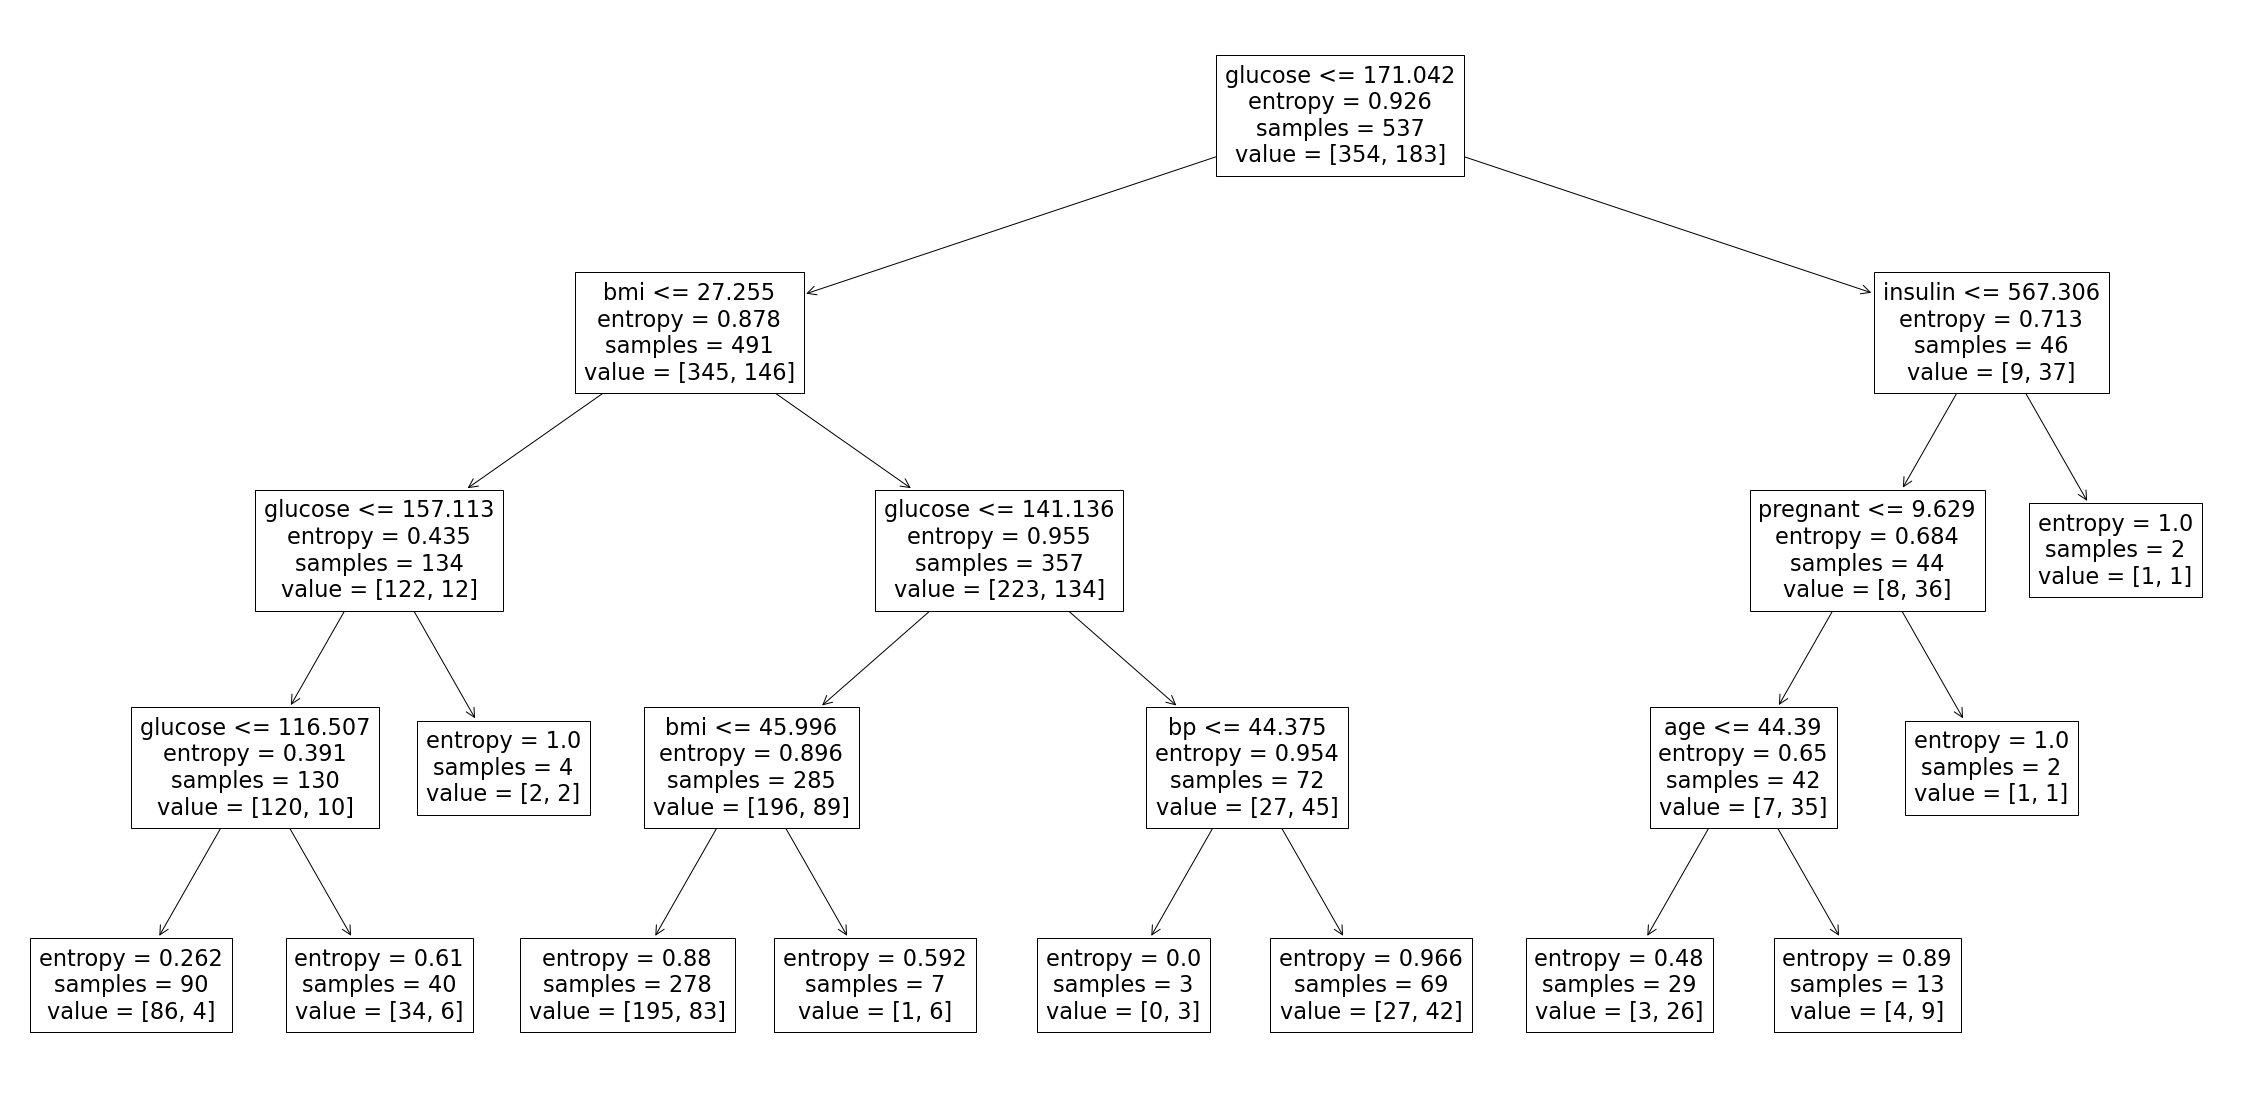

In [59]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(clfAjustado, feature_names = X.columns)
plt.show()

En esta tabla vemos que si , hacemos el recorrido general por el lado izquierdo hasta encontrar la entropia 1 , obsvamos que la decicion cae si la glucosa es  mayor o igual a 157. Siendo izquierda false , derecha true

![Glucosa](./recursos/tabla-niveles-de-glucosa.jpg "Niveles de glucosa")